In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm


import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch

In [2]:

print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())

2.2.2+cu118 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [3]:
device= 'cuda'

The potential function its gradient with respect to x is given by:
$$V(x, y) = 3e^{-x^2 - (y - \frac{1}{3})^2} - 3e^{-x^2 - (y - \frac{5}{3})^2}
         - 5e^{-(x - 1)^2 - y^2} - 5e^{-(x + 1)^2 - y^2}
         + \frac{2}{10}x^4 + \frac{2}{10}(y - \frac{1}{3})^4$$
$$\frac{\partial V}{\partial x} = -6xe^{-x^2-(y-\frac{1}{3})^2} + 6xe^{-x^2-(y-\frac{5}{3})^2} + 10(x-1)e^{- (x-1)^2 - y^2} + 10(x+1)e^{- (x+1)^2 - y^2} + \frac{8}{10}x^3$$
$$\frac{\partial V}{\partial y} = -6(y-\frac{1}{3})e^{-x^2-(y-\frac{1}{3})^2} + 6(y-\frac{5}{3})e^{-x^2-(y-\frac{5}{3})^2} + 10ye^{-(x-1)^2-y^2} + 10ye^{-(x+1)^2-y^2} + \frac{8}{10}(y - \frac{1}{3})^3$$

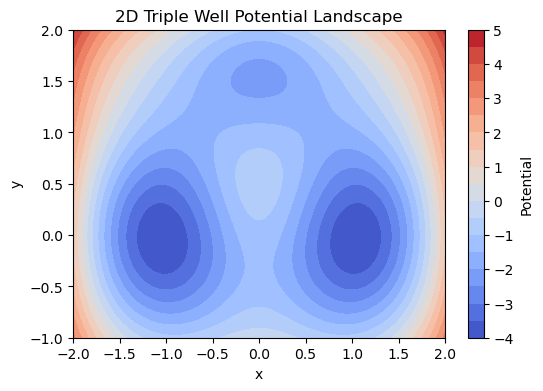

In [4]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

# Calculate the potential at each point
Z = potential(X, Y)

# Plot the potential landscape
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, Z, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
plt.title('2D Triple Well Potential Landscape')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

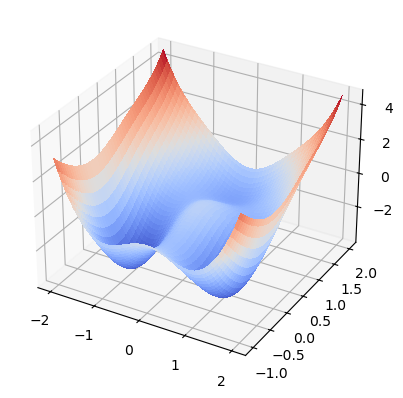

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.contourf(x, y, V, levels=np.linspace(-4.5, 4.5, 20), cmap='coolwarm');
# plt.grid()
surf = ax.plot_surface(X, Y,Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [6]:
## Generate a single trajectory in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 500  # Number of evaluations
lag_time = h * n_steps  # Lag time for each evolution

# Set the initial position
x0 = 0.0
y0 = 0.0

# Set the diffusion coefficient
sigma = 1.09

# Generate the trajectory
x_traj = [x0]
y_traj = [y0]
x = x0
y = y0

for i in tqdm (range(n_eval)):
    for j in range(n_steps):
        dVdx, dVdy = gradient(x, y)
        x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
        y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()
    x_traj.append(x)
    y_traj.append(y)

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

# Calculate the potential at each point
Z = potential(X, Y)

100%|██████████| 500/500 [00:00<00:00, 677.63it/s]


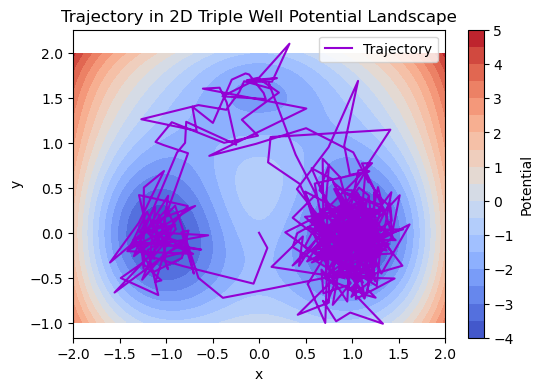

In [7]:
# Plot the potential landscape and the trajectory
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, Z, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
plt.plot(x_traj, y_traj, color= 'darkviolet', linewidth=1.5, label='Trajectory')
plt.title('Trajectory in 2D Triple Well Potential Landscape')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [8]:
## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
h = 1e-3  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 30  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 50

# Set the diffusion coefficient
sigma = 1.09

# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

100%|██████████| 2500/2500 [01:48<00:00, 22.95it/s]


In [9]:
#data_matrix[:, :, 0].ravel()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-2.02832649, -2.00780823, -1.98728996, -1.9667717 , -1.94625343,
        -1.92573516, -1.9052169 , -1.88469863, -1.86418037, -1.8436621 ,
        -1.82314384, -1.80262557, -1.7821073 , -1.76158904, -1.74107077,
        -1.72055251, -1.70003424, -1.67951597, -1.65899771, -1.63847944,
        -1.61796118, -1.59744291, -1.57692465, -1.55640638, -1.53588811,
        -1.51536985, -1.49485158, -1.47433332, -1.45381505, -1.43329678,
        -1.41277852, -1.39226025, -1.37174199, -1.35122372, -1.33070546,
        -1.31018719, -1.28966892, -1.26915066, -1.24863239, -1.22811413,
        -1.20759586, -1.18707759, -1.16655933, -1.14604106, -1.1255228 ,
        -1.10500453, -1.08448627, -1.063968  , -1.04344973, -1.02293147,
        -1.0024132 , 

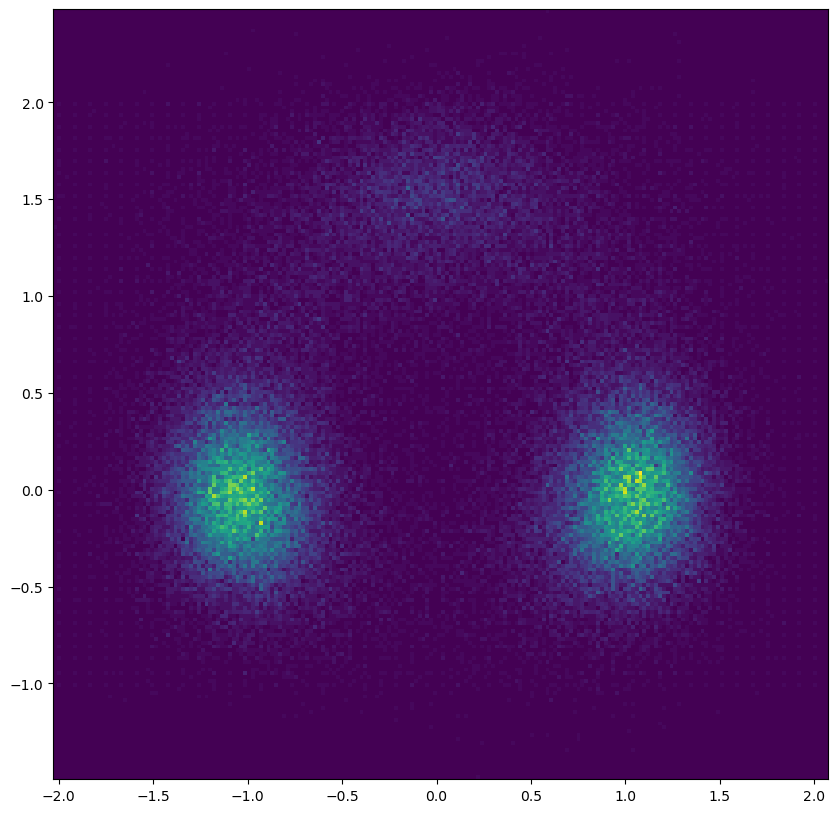

In [10]:
fig2, ax2= plt.subplots(figsize= (10,10))
ax2.hist2d (data_matrix[:, :, 0].ravel(), data_matrix[:, :, 1].ravel(), bins= 200)


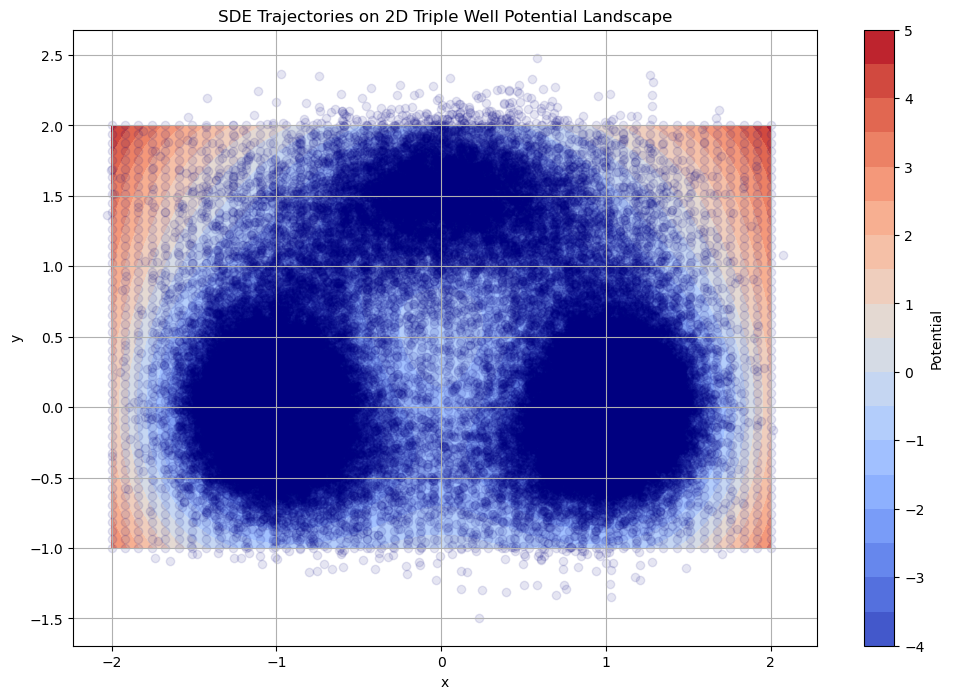

Shape of data_matrix: (2500, 31, 2)


In [11]:
# Calculate the potential at each point
Z = potential(X, Y)

# Plot the potential landscape and the trajectories
plt.figure(figsize=(12, 8))
plt.contourf(X, Y, Z, levels=20, cmap='coolwarm')
plt.colorbar(label='Potential')
for ii in range(m**2):
    plt.scatter(data_matrix[ii, :, 0], data_matrix[ii, :, 1], color= 'navy', alpha=0.1)
plt.title('SDE Trajectories on 2D Triple Well Potential Landscape')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

print("Shape of data_matrix:", data_matrix.shape)

In [12]:
## Save the data to local folder

# Create a folder to store the data (if it doesn't exist)
folder_path = "data"
os.makedirs(folder_path, exist_ok=True)

# Save the data_matrix to a file
file_path = os.path.join(folder_path, "triple_well_2d.npy")
np.save(file_path, data_matrix)

In [13]:
## load the data from local folder
import os
# Load the data_matrix from the file
folder_path = "data"
file_path = os.path.join(folder_path, "triple_well_2d.npy")
data_matrix = np.load(file_path)
data_matrix.shape

(2500, 31, 2)

In [14]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of data_X: (2500, 30, 2)
Shape of data_Y: (2500, 30, 2)
Shape of X: (75000, 2)
Shape of Y: (75000, 2)


In [15]:
n_debug= 2000
# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train00 = X[:int(0.7*len_all)]
data_x_valid00 = X[int(0.7*len_all)+1:]

data_y_train00 = Y[:int(0.7*len_all)]
data_y_valid00 = Y[int(0.7*len_all)+1:]

data_x_train= data_x_train00[:n_debug, :]
data_y_train= data_y_train00[:n_debug, :]

data_x_valid= data_x_valid00[:n_debug, :]
data_y_valid= data_y_valid00[:n_debug, :]


data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

(2000, 2)


In [16]:
data_x_train_tensor = torch.DoubleTensor(data_x_train).to (device)#, requieres_grad= True)#, dtype=tf.float64)
data_y_train_tensor = torch.DoubleTensor(data_y_train).to (device)#, requires_grad= True)#, dtype=tf.float64)

In [17]:
checkpoint_file= 'well2d_example_ckpt004.torch'

In [18]:
basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[25], n_psi_train=22).to(device)  # basis number would be 20

In [19]:
solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

In [20]:
# # Compute the drift and diffusion terms
# #b_Xt, a_Xt = solver.compute_var_coefficients(data_x_train_tensor)
# b_Xt, a_Xt = solver.compute_neural_a_b(data_x_train_tensor)
# print("\nDrift term (b_Xt):")
# print(b_Xt.detach().shape)
# print(b_Xt.detach().cpu().numpy())
# print("\nDiffusion term (a_Xt):")
# print(a_Xt.shape)
# print(a_Xt.detach().cpu().numpy())

In [21]:
# # Compute L_Psi
# L_Psi = solver.compute_generator_L(data_x_train_tensor, b_Xt, a_Xt)

# print("\nL_Psi:")
# print(L_Psi.shape)
# print(L_Psi.detach().cpu().numpy())


In [22]:
# # Calculate the eigenvalues of L_Psi
# eigenvalues =torch.linalg.eig(L_Psi)[0]
# # Extract real parts of the eigenvalues
# real_parts =eigenvalues.real
# # Get the indices that would sort the real parts in descending order
# sorted_indices = torch.argsort(real_parts, descending= True)
# # Use the indices to sort the entire eigenvalues array
# sorted_eigenvalues =eigenvalues[sorted_indices]#torch.gather(eigenvalues, sorted_indices)

# print("\nEigenvalues of L_Psi:")
# print(sorted_eigenvalues.shape)
# print(sorted_eigenvalues.detach().cpu().numpy())

In [23]:

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=1,
    batch_size=256,
    lr=1e-4,
    log_interval=10,
    lr_decay_factor=.8
    )

Epoch: 1 	Training Loss: 0.620399 val loss: 0.573486
saving, val loss enhanced: 0.5734858257323951 10000
Epoch: 2 	Training Loss: 0.607563 val loss: 0.561296
saving, val loss enhanced: 0.5612956542872616 0.5734858257323951
Epoch: 3 	Training Loss: 0.594641 val loss: 0.547819
saving, val loss enhanced: 0.5478193603955309 0.5612956542872616
Epoch: 4 	Training Loss: 0.580601 val loss: 0.533588
saving, val loss enhanced: 0.5335875544263642 0.5478193603955309
Epoch: 5 	Training Loss: 0.567765 val loss: 0.526323
saving, val loss enhanced: 0.5263232666245287 0.5335875544263642
Epoch: 6 	Training Loss: 0.557638 val loss: 0.514169
saving, val loss enhanced: 0.5141694875858324 0.5263232666245287
Epoch: 7 	Training Loss: 0.544980 val loss: 0.504119
saving, val loss enhanced: 0.5041189368620206 0.5141694875858324
Epoch: 8 	Training Loss: 0.533378 val loss: 0.490846
saving, val loss enhanced: 0.4908464152562426 0.5041189368620206
Epoch: 9 	Training Loss: 0.525408 val loss: 0.482647
saving, val loss

Computing dPsi_X: 100%|██████████| 49975/49975 [00:13<00:00, 3839.88iteration/s]


dPsi_X shape:  torch.Size([1999, 25])
psi_x shape:  torch.Size([1999, 25])
psi_x_inv shape:  torch.Size([25, 1999])
cuda:0
cuda:0
Outer Epoch 1/1


Computing dPsi_X: 100%|██████████| 49975/49975 [00:13<00:00, 3727.33iteration/s]


dPsi_X shape:  torch.Size([1999, 25])
psi_x shape:  torch.Size([1999, 25])
psi_x_inv shape:  torch.Size([25, 1999])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 37975.388214 val loss: 42686.982698
saving, val loss enhanced: 42686.982698367145 1000000000000000.0
Epoch: 2 	Training Loss: 37001.824798 val loss: 41799.480960
saving, val loss enhanced: 41799.48096034369 42686.982698367145
Epoch: 3 	Training Loss: 36047.994696 val loss: 40928.269850
saving, val loss enhanced: 40928.26984954831 41799.48096034369
Epoch: 4 	Training Loss: 35113.427748 val loss: 40074.195993
saving, val loss enhanced: 40074.195993351685 40928.26984954831
Epoch: 5 	Training Loss: 34198.817081 val loss: 39237.655200
saving, val loss enhanced: 39237.655200276575 40074.195993351685
Epoch: 6 	Training Loss: 33304.403349 val loss: 38418.673248
saving, val loss enhanced: 38418.67324784917 39237.655200276575
Epoch: 7 	Training Loss: 32430.085028 val loss: 37617.044202
saving, val loss enhanced: 37617.044201646866 38418.673247

In [24]:
# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K
# Psi_X2, Psi_Y2 = solver.get_basis(data_x_train, data_y_train)
# Psi_X2 = Psi_X2.numpy()
# Psi_Y2 = Psi_Y2.numpy()
# jacobian, hessian = solver.get_derivatives(data_x_valid) # Currently the storage is not enough to calculate for larger amount of data
# np_config.enable_numpy_behavior()
outputs = {
    'efuns': efuns,
    'evalues': evalues,
    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    # 'Psi_X2': Psi_X2,
    # 'Psi_Y2': Psi_Y2,
    # "Jacobian": jacobian,  # Uncomment if needed
    # "Hessian": hessian,    # Uncomment if needed
    }

In [25]:
print(evalues.shape)
print(evalues)

(25,)
[ 1.00000134e+00+0.00000000e+00j  9.89250824e-01+0.00000000e+00j
  7.95089226e-01+0.00000000e+00j  4.95675676e-01+0.00000000e+00j
  4.04215133e-01+0.00000000e+00j  3.05347905e-01+0.00000000e+00j
  2.92028356e-01+0.00000000e+00j  1.78285453e-01+0.00000000e+00j
  6.76519277e-02+1.26503974e-02j  6.76519277e-02-1.26503974e-02j
  3.77357996e-02+0.00000000e+00j  9.30571759e-03+0.00000000e+00j
  4.50475249e-03+0.00000000e+00j  3.15515266e-04+0.00000000e+00j
  1.31230099e-05+0.00000000e+00j  3.93201172e-06+0.00000000e+00j
  9.20725306e-07+6.22757676e-07j  9.20725306e-07-6.22757676e-07j
  3.21391377e-08+0.00000000e+00j  4.09178813e-09+0.00000000e+00j
  1.57008859e-10+0.00000000e+00j  7.40174732e-11+0.00000000e+00j
 -2.30168485e-11+0.00000000e+00j -6.38936340e-06+1.73936635e-05j
 -6.38936340e-06-1.73936635e-05j]


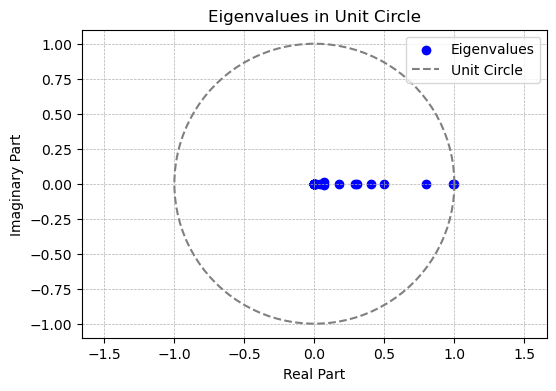

In [26]:
## Plot eigenvalues on unit circle
# Assuming evalues is a numpy array of complex numbers
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [27]:
np.log(real_parts)

C:\Users\Jason\AppData\Local\Temp\ipykernel_15080\2154100952.py:1: RuntimeWarning: invalid value encountered in log
  np.log(real_parts)


array([ 1.33660042e-06, -1.08073653e-02, -2.29300937e-01, -7.01833444e-01,
       -9.05808037e-01, -1.18630348e+00, -1.23090437e+00, -1.72436935e+00,
       -2.69337943e+00, -2.69337943e+00, -3.27714604e+00, -4.67712627e+00,
       -5.40262233e+00, -8.06130349e+00, -1.12411434e+01, -1.24463594e+01,
       -1.38981041e+01, -1.38981041e+01, -1.72531913e+01, -1.93142838e+01,
       -2.25747189e+01, -2.33267199e+01,             nan,             nan,
                   nan])

In [28]:
efuns_real = np.real(efuns)
print(efuns_real.shape)
print(efuns_real)

(75000, 25)
[[-1.09026939e+00 -5.70125951e-02  8.74387355e-03 ...  1.35647365e-06
  -5.09847292e-05 -5.09847292e-05]
 [-1.08891315e+00 -5.31316682e-02  2.33807118e-02 ...  6.72995481e-08
  -5.40418794e-05 -5.40418794e-05]
 [-1.08949644e+00 -4.58502753e-02  1.51256487e-02 ...  5.55178463e-09
  -8.57564440e-06 -8.57564440e-06]
 ...
 [-1.08944342e+00 -5.40794845e-02  1.24256021e-02 ...  9.09285408e-09
   4.96987947e-06  4.96987947e-06]
 [-1.08942563e+00 -5.59917686e-02  9.78811371e-03 ...  1.22774931e-08
   1.82292339e-05  1.82292339e-05]
 [-1.08935294e+00 -6.06437272e-02  9.02129807e-03 ...  7.37514363e-09
   1.42132250e-05  1.42132250e-05]]


In [29]:
X.shape

(75000, 2)

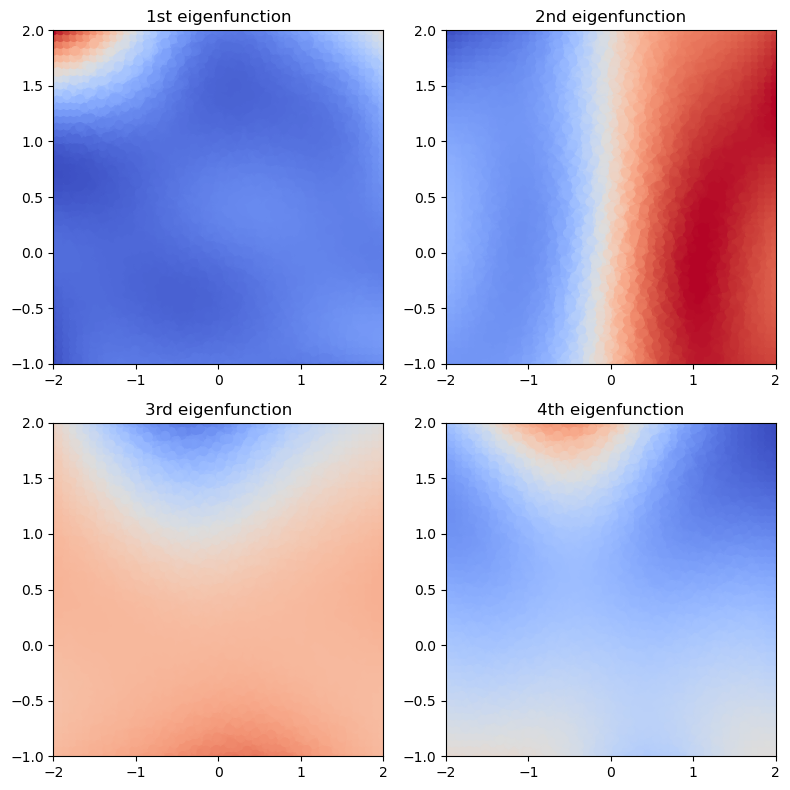

In [30]:
## Plot eigenfunctions
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(ncols=2, nrows=2)

# Plot for the 1st eigenfunction
ax1 = fig.add_subplot(gs[0, 0])#, subplot_kw={"projection": "3d"})
scatter1 = ax1.scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
ax1.set_title('1st eigenfunction')
ax1.set_xlim(-2, 2)  # Correct x-axis limits
ax1.set_ylim(-1, 2)  # Correct y-axis limits

# Plot for the 2nd eigenfunction
ax2 = fig.add_subplot(gs[0, 1])
scatter2 = ax2.scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
ax2.set_title('2nd eigenfunction')
ax2.set_xlim(-2, 2)  # Corrected x-axis limits
ax2.set_ylim(-1, 2)  # Corrected y-axis limits

# Plot for the 3rd eigenfunction
ax3 = fig.add_subplot(gs[1, 0])
scatter3 = ax3.scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
ax3.set_title('3rd eigenfunction')
ax3.set_xlim(-2, 2)  # Corrected x-axis limits
ax3.set_ylim(-1, 2)  # Corrected y-axis limits

# Plot for the 4th eigenfunction
ax4 = fig.add_subplot(gs[1, 1])
scatter4 = ax4.scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
ax4.set_title('4th eigenfunction')
ax4.set_xlim(-2, 2)  # Corrected x-axis limits
ax4.set_ylim(-1, 2)  # Corrected y-axis limits

plt.tight_layout()
plt.show()

In [31]:
# ## Plot eigenfunctions
# # Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# # and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# fig = plt.figure(figsize=(8, 8))
# gs = fig.add_gridspec(ncols=2, nrows=2)

# # Plot for the 1st eigenfunction
# ax1 = fig.add_subplot(gs[0, 0])
# #scatter1 = ax1.scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
# ax.plot_surface(X[:, 0], X[:,1],np.real(efuns)[:, 0], cmap=cm.coolwarm)
                       
# ax1.set_title('1st eigenfunction')
# # ax1.set_xlim(-2, 2)  # Correct x-axis limits
# # ax1.set_ylim(-1, 2)  # Correct y-axis limits

# # Plot for the 2nd eigenfunction
# ax2 = fig.add_subplot(gs[0, 1])
# scatter2 = ax2.scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
# ax2.set_title('2nd eigenfunction')
# ax2.set_xlim(-2, 2)  # Corrected x-axis limits
# ax2.set_ylim(-1, 2)  # Corrected y-axis limits

# # Plot for the 3rd eigenfunction
# ax3 = fig.add_subplot(gs[1, 0])
# scatter3 = ax3.scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
# ax3.set_title('3rd eigenfunction')
# ax3.set_xlim(-2, 2)  # Corrected x-axis limits
# ax3.set_ylim(-1, 2)  # Corrected y-axis limits

# # Plot for the 4th eigenfunction
# ax4 = fig.add_subplot(gs[1, 1])
# scatter4 = ax4.scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
# ax4.set_title('4th eigenfunction')
# ax4.set_xlim(-2, 2)  # Corrected x-axis limits
# ax4.set_ylim(-1, 2)  # Corrected y-axis limits

# plt.tight_layout()
# plt.show()

In [32]:
X[:, 1]

array([-1.        , -0.7926265 , -0.42237229, ..., -0.38728914,
       -0.14400046, -0.08183625])